In [5]:
%matplotlib inline
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import copy
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Copy paste från lab0
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 10)
        print(f"Device: {str(self.device).upper()}")

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
def evaluation_metrics(correct_predictions, total_predictions, all_targets, all_predictions, all_probs, display_cm = True):
    accuracy = correct_predictions / total_predictions
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    auc = roc_auc_score(all_targets, [p[1] for p in all_probs])
        
    print(f"\rAccuracy  : {accuracy*100:.2f}%")
    print(f"Precision : {precision*100:.2f}%")
    print(f"Recall    : {recall*100:.2f}%")
    print(f"F1 Score  : {f1*100:.2f}%")
    print(f"AUC Score : {auc*100:.2f}%")
    if display_cm:
        cm = confusion_matrix(all_targets, all_predictions)
        plt.figure(figsize=(4,4))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.show()

In [22]:
def train_and_validate(nn, train_loader, val_loader, criterion, optimizer, num_epochs, print_seperate = False, patience=5) -> None:
    """
    Train and validate a neural network model with early stopping.

    Parameters:
    - nn : torch.nn.Module
        The neural network model to train and validate.
    - train_loader : DataLoader
        The DataLoader containing the training dataset.
    - val_loader : DataLoader
        The DataLoader containing the validation dataset.
    - criterion : torch.nn.Module
        The loss function to use.
    - optimizer : torch.optim.Optimizer
        The optimizer to use.
    - num_epochs : int
        The number of epochs to train the model.
    - patience : int
        The number of epochs to wait for improvement in validation loss before stopping.
    """

    nn.to(nn.device)

    n = int(len(str(abs(num_epochs))))
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        nn.train()
        total_train_loss = 0

        ind = 0
        for batch in train_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(nn.device), labels.to(nn.device)

            optimizer.zero_grad()
            outputs = nn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            print(f"\rTraining.. Epoch [{epoch+1:>n}/{num_epochs:>n}], ({ind+1:>3}/{len(train_loader)})", end="")
            ind += 1

        nn.eval()
        total_val_loss = 0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            ind = 0
            for batch in val_loader:
                inputs, labels = batch
                inputs, labels = inputs.to(nn.device), labels.to(nn.device)

                outputs = nn(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_predictions += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()
                print(f"\rValidating Epoch [{epoch+1:>n}/{num_epochs:>n}], ({ind+1:>3}/{len(val_loader):>3})", end="")
                ind += 1

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        accuracy = correct_predictions / total_predictions


        print(f'\r.......... Epoch [{epoch+1:>n}/{num_epochs:>n}], ({len(val_loader):>3}/{len(val_loader):>3}), Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy*100:.2f}%', end="")
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f" Early stopping: {epochs_no_improve}/{patience}", end="")
            if epochs_no_improve >= patience:
                print(f"\nNo improvement in {epochs_no_improve} epochs, stopping early.")
                break
        # Early stopping 
        if print_seperate:
            print()
    print()

        


def test_model(nn, test_loader, display_cm = True) -> None:
    """
    Test a neural network model on a given dataset.

    Parameters:
    - model : torch.nn.Module
        The trained neural network model to test.
    - test_loader : DataLoader
        The DataLoader for the test dataset.
    """


    print("\rTesting...", end = "")
    nn.to(nn.device)
    nn.eval()
    
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_targets = []
    all_probs = []


    with torch.no_grad(): 
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(nn.device), labels.to(nn.device)
            outputs = nn(inputs)
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            # För F1, Rec, Pre, AUC:
            probs = torch.softmax(outputs, dim=1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())


    # Compute evalulation metrics
    evaluation_metrics(correct_predictions, total_predictions, all_targets, all_predictions, all_probs, display_cm)



In [10]:

def ensemble_prediction(models: list[torch.nn.Module], inputs: torch.Tensor):
    device = models[0].device
    for model in models:
        model.eval()
        model.to(device)

    # Averagar modellernas output, vi borde testa typ weighted averaging och eller boosting
    with torch.no_grad():
        outputs = sum(model(inputs) for model in models) / len(models)
        return outputs
    

def test_ensemble(models: list[torch.nn.Module], test_loader: DataLoader, display_cm = True):
    device = models[0].device
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = ensemble_prediction(models, inputs)
            _, predicted = torch.max(outputs.data, 1)

            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            # För F1, Rec, Pre, AUC:
            probs = torch.softmax(outputs, dim=1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    evaluation_metrics(correct_predictions, total_predictions, all_targets, all_predictions, all_probs, display_cm)
    

In [14]:
#local_directory = "C:/Users/hampu/Documents/kurser/år3/d7047e/images"
local_directory = "C:/Users/hampek/Documents/school/d7047e/images"

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4815], std=[0.2221]) # <-- beräknat med compute_mean_std() mean=[0.4815], std=[0.2221]
])

full_dataset = ImageFolder(root=local_directory, transform=transform)

# 70/15/15 split
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


batch_size = 32
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True,  num_workers = num_workers)
val_loader   = DataLoader(val_dataset,   batch_size = batch_size, shuffle=False, num_workers = num_workers)
test_loader  = DataLoader(test_dataset,  batch_size = batch_size, shuffle=False, num_workers = num_workers)



In [12]:
def compute_mean_std(): 
    # tar fram mean och std för hela datasettet, till transform
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

    data = ImageFolder(root=local_directory, transform=transform)

    loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False)

    mean = 0
    std = 0
    total_samples = 0
    for data, _ in loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples

    print("Mean:", mean)
    print("Std:", std)

Device: CPU
.......... Epoch [1/100], ( 28/ 28), Train Loss: 0.4527, Val Loss: 0.1581, Accuracy: 94.42%
.......... Epoch [2/100], ( 28/ 28), Train Loss: 0.1526, Val Loss: 0.1395, Accuracy: 95.33%
.......... Epoch [3/100], ( 28/ 28), Train Loss: 0.1186, Val Loss: 0.1397, Accuracy: 94.65% Early stopping: 1/5
.......... Epoch [4/100], ( 28/ 28), Train Loss: 0.1045, Val Loss: 0.1362, Accuracy: 95.10%
.......... Epoch [5/100], ( 28/ 28), Train Loss: 0.0862, Val Loss: 0.1766, Accuracy: 93.74% Early stopping: 1/5
.......... Epoch [6/100], ( 28/ 28), Train Loss: 0.0584, Val Loss: 0.1542, Accuracy: 94.87% Early stopping: 2/5
.......... Epoch [7/100], ( 28/ 28), Train Loss: 0.0550, Val Loss: 0.1641, Accuracy: 94.53% Early stopping: 3/5
.......... Epoch [8/100], ( 28/ 28), Train Loss: 0.0372, Val Loss: 0.1646, Accuracy: 94.65% Early stopping: 4/5
.......... Epoch [9/100], ( 28/ 28), Train Loss: 0.0416, Val Loss: 0.1799, Accuracy: 94.87% Early stopping: 5/5
No improvement in 5 epochs, stopping ear

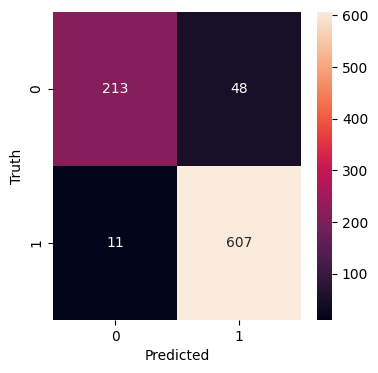

In [23]:
model = CNN()
num_epochs = 100
learning_rate = 0.001

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, print_seperate=True)
test_model(model, test_loader)


In [254]:
# Denna använder resnet18, googlenet, och densenet121
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0256630

resnet18    = models.resnet18()
googlenet   = models.googlenet()
densenet121 = models.densenet121()

_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18.device    = _device
googlenet.device   = _device
densenet121.device = _device

resnet18.fc            = torch.nn.Linear(resnet18.fc.in_features, 2)
googlenet.fc           = torch.nn.Linear(googlenet.fc.in_features, 2)
densenet121.classifier = torch.nn.Linear(densenet121.classifier.in_features, 2)

#cnn = CNN()

num_epochs = 10
learning_rate = 0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for model in [resnet18, googlenet, densenet121]:
    print(model.__class__.__name__)
    train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, print_seperate=True)
    test_model(model, test_loader, display_cm = False)

print("Ensemble test:")
test_ensemble([resnet18, googlenet, densenet121], test_loader)


c:\Users\hampek\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


ResNet
.......... Epoch [1/10], ( 28/ 28), Train Loss: 0.7667, Val Loss: 0.7641, Accuracy: 25.17%
.......... Epoch [2/10], ( 28/ 28), Train Loss: 0.7684, Val Loss: 0.7647, Accuracy: 24.26%
.......... Epoch [3/10], ( 28/ 28), Train Loss: 0.7671, Val Loss: 0.7675, Accuracy: 25.85%
.......... Epoch [4/10], ( 28/ 28), Train Loss: 0.7676, Val Loss: 0.7654, Accuracy: 23.58%
.......... Epoch [5/10], ( 28/ 28), Train Loss: 0.7656, Val Loss: 0.7668, Accuracy: 24.15%
.......... Epoch [6/10], ( 28/ 28), Train Loss: 0.7673, Val Loss: 0.7653, Accuracy: 24.72%
.......... Epoch [7/10], ( 28/ 28), Train Loss: 0.7666, Val Loss: 0.7674, Accuracy: 23.80%
.......... Epoch [8/10], ( 28/ 28), Train Loss: 0.7666, Val Loss: 0.7694, Accuracy: 24.37%
.......... Epoch [9/10], ( 28/ 28), Train Loss: 0.7675, Val Loss: 0.7620, Accuracy: 24.94%
.......... Epoch [10/10], ( 28/ 28), Train Loss: 0.7667, Val Loss: 0.7660, Accuracy: 24.26%

Accuracy  : 26.39%
Precision : 34.68%
Recall    : 26.39%
F1 Score  : 15.40%
AUC S

TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not GoogLeNetOutputs